# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns.

In [22]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [23]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [24]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [25]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [26]:
feat_info.head(20)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help me make cleaning decisions during this stage of the project. First of all, I will assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll need to do a little bit of parsing to make use of it to identify and clean the data.  Then, I convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. I might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

## Code

### Explore Data

In [27]:
azdias.shape

(891221, 85)

In [28]:
# Identify missing or unknown data values and convert them to NaNs.

azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [29]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

### Change missing values to Nans

In [30]:
for i in range(0,len(feat_info)):
    attribute = feat_info['attribute'][i]
    nans = feat_info['missing_or_unknown'][i][1:-1].split(',')
    for nan in nans:
        if (nan != '') & (nan != 'X') & (nan != 'XX'):
            nan = int(nan)
        azdias[attribute] = azdias[attribute].replace(nan, np.nan)

### Test

In [31]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column


In [32]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias.isnull().sum().sort_values(ascending = False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

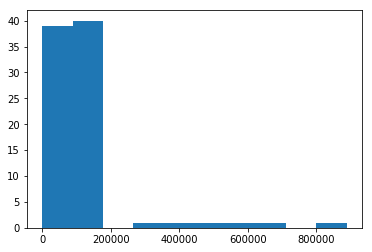

In [33]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(azdias.isnull().sum());

## The outlying data (defined as the 93rd percentile) is composed of six attributes:

1.  TITEL_KZ (academic title flag) - 889,061 Nans
2.  AGER_TYP (segmentation of elderly) - 685,843 Nans
3.  KK_KUNDENTYP (consumer pattern) - 584,612 Nans
4.  KBA05_BAUMAX (Most common building within microcell) - 476,524 Nans
5.  GEBURTSJAHR (year of birth) - 392,318 Nans
6.  ALTER_HH (head of household birthdate) - 310,267 Nans

In [34]:
# Remove the outlier columns from the dataset.

azdias = azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)

## Test

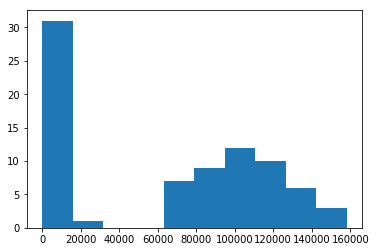

In [35]:
plt.hist(azdias.isnull().sum());

#### Discussion 1.1.2: Assess Missing Data in Each Column

#### I defined an outlier as the data in the 93rd percentile because this made sense when visually inspecting the histogram.  The removed, outlying data (defined as the 93rd percentile) was composed of six attributes:

1.  TITEL_KZ (academic title flag) - 889,061 Nans
2.  AGER_TYP (segmentation of elderly) - 685,843 Nans
3.  KK_KUNDENTYP (consumer pattern) - 584,612 Nans
4.  KBA05_BAUMAX (Most common building within microcell) - 476,524 Nans
5.  GEBURTSJAHR (year of birth) - 392,318 Nans
6.  ALTER_HH (head of household birthdate) - 310,267 Nans

#### There are a couple commonalities in these:

1.  TITEL_KZ and AGER_TYP were both classifiers on subsegments of the population, namely those with academic titles and the elderly.
2.  Also, birthdates seem to be difficult to acquire, which is why GEBURTSJAHR and ALTER_HH had so much missing data.

#### Step 1.1.3: Assess Missing Data in Each Row


In [36]:
# How much data is missing in each row of the dataset?

azdias.isnull().sum(axis=1).sort_values(ascending = False)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

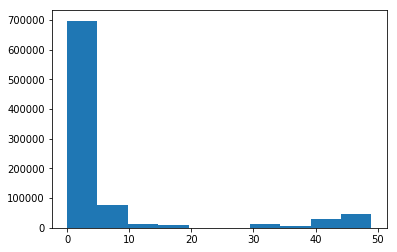

In [37]:
plt.hist(azdias.isnull().sum(axis=1));

In [38]:
azdias[azdias.isnull().sum(axis=1) > 25].shape

(93260, 79)

In [39]:
azdias[azdias.isnull().sum(axis=1) <= 25].shape

(797961, 79)

In [40]:
# Divide the data into two subsets based on the number of missing
# values in each row.

azdias_high_nan = azdias[azdias.isnull().sum(axis=1) > 25]
azdias_low_nan = azdias[azdias.isnull().sum(axis=1) <= 25]

In [41]:
azdias.isnull().sum().sort_values(ascending = False)

KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
MOBI_REGIO               133324
KBA05_ANTG4              133324
KBA05_ANTG3              133324
KBA05_ANTG2              133324
KBA05_ANTG1              133324
KBA05_GBZ                133324
PLZ8_ANTG2               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_BAUMAX              116515
PLZ8_HHZ                 116515
PLZ8_GBZ                 116515
HEALTH_TYP               111196
SHOPPER_TYP              111196
VERS_TYP                 111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DEUG_2015           99352
LP_LEBENSPHASE_FEIN       97632
RELAT_AB                  97375
ARBEIT                    97375
ORTSGR_KLS9               97274
                          ...  
GFK_URLA

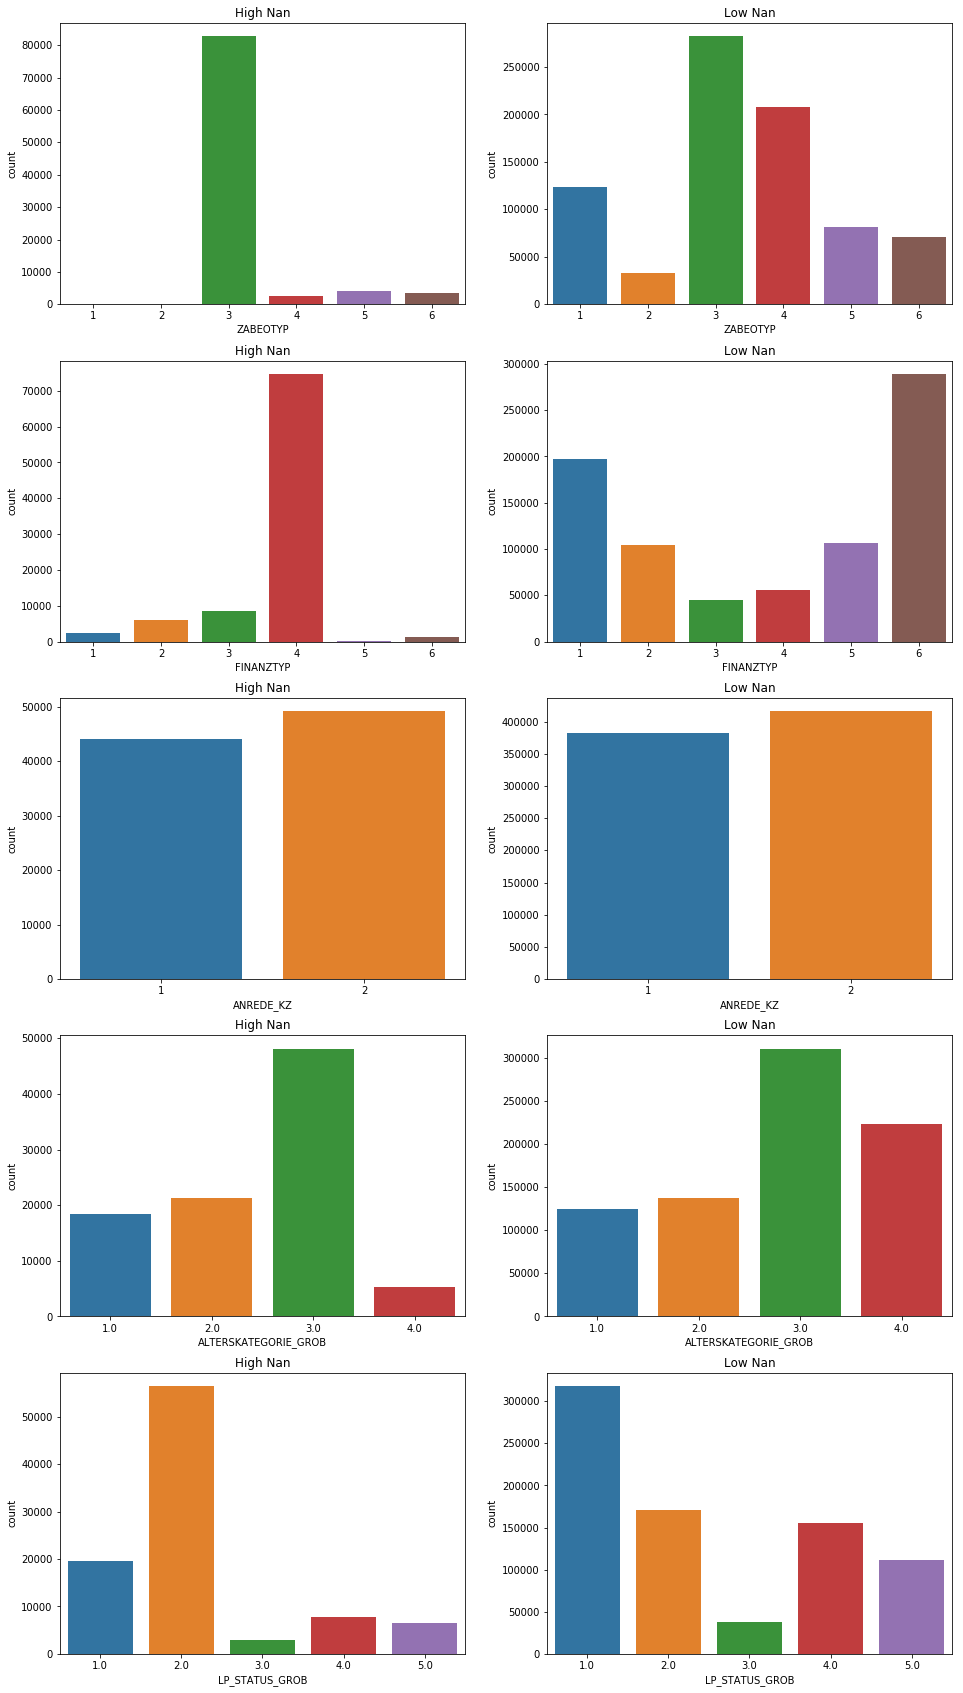

In [42]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#ZABEOTYP (green / energy consumption)
#FINANZTYP (financial type)
#ANREDE_KZ (male/female),
#ALTERSKATEGORIE_GROB (age)
#LP_STATUS_GROB (financial status)


fig, ax = plt.subplots(5,2, figsize=(16,30))

ax[0,0].set_title('High Nan')
ax[0,1].set_title('Low Nan')
ax[1,0].set_title('High Nan')
ax[1,1].set_title('Low Nan')
ax[2,0].set_title('High Nan')
ax[2,1].set_title('Low Nan')
ax[3,0].set_title('High Nan')
ax[3,1].set_title('Low Nan')
ax[4,0].set_title('High Nan')
ax[4,1].set_title('Low Nan')

sns.countplot(azdias_high_nan['ZABEOTYP'], ax=ax[0,0])
sns.countplot(azdias_low_nan['ZABEOTYP'], ax=ax[0,1])
sns.countplot(azdias_high_nan['FINANZTYP'], ax=ax[1,0])
sns.countplot(azdias_low_nan['FINANZTYP'], ax=ax[1,1])
sns.countplot(azdias_high_nan['ANREDE_KZ'], ax=ax[2,0])
sns.countplot(azdias_low_nan['ANREDE_KZ'], ax=ax[2,1])
sns.countplot(azdias_high_nan['ALTERSKATEGORIE_GROB'], ax=ax[3,0])
sns.countplot(azdias_low_nan['ALTERSKATEGORIE_GROB'], ax=ax[3,1])
sns.countplot(azdias_high_nan['LP_STATUS_GROB'], ax=ax[4,0])
sns.countplot(azdias_low_nan['LP_STATUS_GROB'], ax=ax[4,1])
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

#### The data with a lot of null values was predominantly:

1.  "Fair Supplied" Energy consumers
2.  "Be Prepared" Finance types
3.  People likely to be younger than 60 years old based on name analysis
4.  Average earners

#### There was no difference in gender

#### This high null-value data composed roughly 10% of the whole dataset.  Thankfully, most of the high null-value data appears to have been composed of fairly average person data, so we are unlikely to be losing insights.

#### I make the low_nan values my dataset

In [43]:
azdias = azdias_low_nan.copy()

### Step 1.2: Select and Re-Encode Features


In [44]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [45]:
# How many features are there of each data type?

feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features


- For binary (two-level) categoricals that take numeric values, I can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis if they are redundant with other features.

In [46]:
# Assess categorical variables

feat_info_cat_mix = feat_info[(feat_info['type'] == 'categorical') | (feat_info['type'] == 'mixed')].reset_index()

In [47]:
feat_info_cat_mix

,index,attribute,information_level,type,missing_or_unknown
0,0,AGER_TYP,person,categorical,"[-1,0]"
1,2,ANREDE_KZ,person,categorical,"[-1,0]"
2,3,CJT_GESAMTTYP,person,categorical,[0]
3,10,FINANZTYP,person,categorical,[-1]
4,12,GFK_URLAUBERTYP,person,categorical,[]
5,13,GREEN_AVANTGARDE,person,categorical,[]
6,15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
7,16,LP_LEBENSPHASE_GROB,person,mixed,[0]
8,17,LP_FAMILIE_FEIN,person,categorical,[0]
9,18,LP_FAMILIE_GROB,person,categorical,[0]


In [48]:
cat_mix_list = []
cat_mix_list2 = []

        
for i in range (0,len(feat_info_cat_mix['attribute'])):
    att = feat_info_cat_mix['attribute'][i]
    if att in list(azdias):
        vals = azdias[att].unique()
        cat_mix_list.append(att)
        cat_mix_list2.append(vals)
        
cat_mix_list = list(zip(cat_mix_list, cat_mix_list2))

In [49]:
cat_mix_list

[('ANREDE_KZ', array([2, 1])),
 ('CJT_GESAMTTYP', array([  5.,   3.,   2.,   4.,   1.,   6.,  nan])),
 ('FINANZTYP', array([1, 6, 5, 2, 4, 3])),
 ('GFK_URLAUBERTYP',
  array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   2.,   7.,
           6.,  nan])),
 ('GREEN_AVANTGARDE', array([0, 1])),
 ('LP_LEBENSPHASE_FEIN',
  array([ 21.,   3.,  nan,  32.,   8.,   2.,   5.,  10.,   4.,   6.,  23.,
          12.,  20.,   1.,  11.,  25.,  13.,  18.,  31.,  38.,  35.,  30.,
           7.,  22.,  14.,  29.,  24.,  28.,  37.,  26.,  39.,  27.,  36.,
           9.,  34.,  33.,  15.,  40.,  16.,  19.,  17.])),
 ('LP_LEBENSPHASE_GROB',
  array([  6.,   1.,  nan,  10.,   2.,   3.,   5.,   7.,  12.,  11.,   9.,
           4.,   8.])),
 ('LP_FAMILIE_FEIN',
  array([  5.,   1.,  nan,  10.,   2.,   7.,  11.,   8.,   4.,   6.,   9.,
           3.])),
 ('LP_FAMILIE_GROB', array([  3.,   1.,  nan,   5.,   2.,   4.])),
 ('LP_STATUS_FEIN',
  array([  2.,   3.,   9.,   4.,   1.,  10.,   5.,   8.,   6.,

In [50]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': '1', 'O': '0'})

In [51]:
azdias = azdias.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP' , 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
            'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
             'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

#### I kept ANREDE_KZ, GREEN_AVANTGARDE, and SOHO_KZ because they were already binary.  I kept OST_WEST_KZ because I could easily map its two values to 1's and 0's.  I elected to drop the rest of the categorical features from the dataset because their data seemed largely redundant with other features.

#### Step 1.2.2: Engineer Mixed-Type Features


- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PJ_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['PJ_Movement'] = azdias['PRAEGENDE_JUGENDJAHRE']

In [53]:
azdias['PJ_Decade'].loc[(azdias['PJ_Decade'] == 1) | (azdias['PJ_Decade'] == 2)] = 1
azdias['PJ_Decade'].loc[(azdias['PJ_Decade'] == 3) | (azdias['PJ_Decade'] == 4)] = 2
azdias['PJ_Decade'].loc[(azdias['PJ_Decade'] == 5) | (azdias['PJ_Decade'] == 6) | (azdias['PJ_Decade'] == 7)] = 3
azdias['PJ_Decade'].loc[(azdias['PJ_Decade'] == 8) | (azdias['PJ_Decade'] == 9)] = 4
azdias['PJ_Decade'].loc[(azdias['PJ_Decade'] == 10) | (azdias['PJ_Decade'] == 11) | (azdias['PJ_Decade'] == 12) | (azdias['PJ_Decade'] == 13)] = 5
azdias['PJ_Decade'].loc[(azdias['PJ_Decade'] == 14) | (azdias['PJ_Decade'] == 15)] = 6

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [54]:
azdias['PJ_Movement'].loc[(azdias['PJ_Movement'] == 1) | (azdias['PJ_Movement'] == 3)| (azdias['PJ_Movement'] == 5)
                         | (azdias['PJ_Movement'] == 8) | (azdias['PJ_Movement'] == 10) | (azdias['PJ_Movement'] == 12)
                         | (azdias['PJ_Movement'] == 14)] = 1

azdias['PJ_Movement'].loc[(azdias['PJ_Movement'] == 2) | (azdias['PJ_Movement'] == 4)| (azdias['PJ_Movement'] == 6)
                         | (azdias['PJ_Movement'] == 7) | (azdias['PJ_Movement'] == 9) | (azdias['PJ_Movement'] == 11)
                         | (azdias['PJ_Movement'] == 13) | (azdias['PJ_Movement'] == 15)] = 2

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [55]:
azdias['ANREDE_KZ'].unique()

array([2, 1])

In [56]:
azdias['PJ_Decade'].unique()

array([  6.,   4.,   2.,   5.,   3.,  nan,   1.])

In [57]:
azdias['PJ_Movement'].unique()

array([  1.,   2.,  nan])

In [58]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CI2_Wealth'] = pd.to_numeric(azdias['CAMEO_INTL_2015'].str[0])
azdias['CI2_LifeStage'] = pd.to_numeric(azdias['CAMEO_INTL_2015'].str[1])

In [59]:
azdias[['CAMEO_INTL_2015', 'CI2_Wealth', 'CI2_LifeStage', 'PRAEGENDE_JUGENDJAHRE', 'PJ_Decade', 'PJ_Movement']].head()

,CAMEO_INTL_2015,CI2_Wealth,CI2_LifeStage,PRAEGENDE_JUGENDJAHRE,PJ_Decade,PJ_Movement
1,51,5.0,1.0,14.0,6.0,1.0
2,24,2.0,4.0,15.0,6.0,2.0
3,12,1.0,2.0,8.0,4.0,1.0
4,43,4.0,3.0,8.0,4.0,1.0
5,54,5.0,4.0,3.0,2.0,1.0


#### Discussion 1.2.2: Engineer Mixed-Type Features


#### The remaining mixed-type features are:

1.  LP_LEBENSPHASE_FEIN - Life stage at a fine scale - This is largely redundant with CAMEO_INTL_2015 LifeStage
2.  LP_LEBENSPHASE_GROB - Life stage at a rough scale - This is largely redundant with CAMEO_INTL_2015 LifeStage
3.  WOHNLAGE - Neighborhood quality - This is redundant with REGIOTYP (Neighborhood Typology)
4.  PLZ8_BAUMAX - Most common building type within the PLZ8 region - This is redundant with the PLZ8_ANTG1 to PLZ8_ANTG4 features

#### Due to the redundancy of the other mixed-type features, I elected to drop them from the dataset.

In [60]:
azdias = azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1)

#### Step 1.2.3: Complete Feature Selection

#### I also drop the mixed features I used to create individual features

In [62]:
azdias = azdias.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1)

### Step 1.3: Create a Cleaning Function


In [63]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for i in range(0,len(feat_info)):
        attribute = feat_info['attribute'][i]
        nans = feat_info['missing_or_unknown'][i][1:-1].split(',')
        for nan in nans:
            if (nan != '') & (nan != 'X') & (nan != 'XX'):
                nan = int(nan)
            df[attribute] = df[attribute].replace(nan, np.nan)
    
    # remove selected columns and rows, ...
    
    df = df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)
    
    df = df[df.isnull().sum(axis=1) <= 25]
    
    # select, re-encode, and engineer column values.
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': '1', 'O': '0'})
    
    df = df.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP' , 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
            'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
             'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis=1)
    
    df['PJ_Decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PJ_Movement'] = df['PRAEGENDE_JUGENDJAHRE']
    
    df['PJ_Decade'].loc[(df['PJ_Decade'] == 1) | (df['PJ_Decade'] == 2)] = 1
    df['PJ_Decade'].loc[(df['PJ_Decade'] == 3) | (df['PJ_Decade'] == 4)] = 2
    df['PJ_Decade'].loc[(df['PJ_Decade'] == 5) | (df['PJ_Decade'] == 6) | (df['PJ_Decade'] == 7)] = 3
    df['PJ_Decade'].loc[(df['PJ_Decade'] == 8) | (df['PJ_Decade'] == 9)] = 4
    df['PJ_Decade'].loc[(df['PJ_Decade'] == 10) | (df['PJ_Decade'] == 11) | (df['PJ_Decade'] == 12) | (df['PJ_Decade'] == 13)] = 5
    df['PJ_Decade'].loc[(df['PJ_Decade'] == 14) | (df['PJ_Decade'] == 15)] = 6
    
    df['PJ_Movement'].loc[(df['PJ_Movement'] == 1) | (df['PJ_Movement'] == 3)| (df['PJ_Movement'] == 5)
                         | (df['PJ_Movement'] == 8) | (df['PJ_Movement'] == 10) | (df['PJ_Movement'] == 12)
                         | (df['PJ_Movement'] == 14)] = 1

    df['PJ_Movement'].loc[(df['PJ_Movement'] == 2) | (df['PJ_Movement'] == 4)| (df['PJ_Movement'] == 6)
                         | (df['PJ_Movement'] == 7) | (df['PJ_Movement'] == 9) | (df['PJ_Movement'] == 11)
                         | (df['PJ_Movement'] == 13) | (df['PJ_Movement'] == 15)] = 2
    
    df['CI2_Wealth'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[0])
    df['CI2_LifeStage'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[1])
    
    df = df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX'], axis=1)
    df = df.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, I need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

#### Rows with no null values compose 78% of the data (623,000 rows)

In [64]:
azdias.dropna().shape[0] / azdias.shape[0]

0.7810043347983172

#### Because we'll be performing clustering on this data, I fill null values with the means of the columns to avoid losing information.

In [65]:
azdias = azdias.fillna(azdias.mean())

In [66]:
azdias.dropna().shape[0] / azdias.shape[0]

1.0

In [67]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias[azdias.columns] = scaler.fit_transform(azdias[azdias.columns])

#### Below, we observe that the mean of each feature is approximately 0, and the standard deviation is approximately 1.

In [68]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_Decade,PJ_Movement,CI2_Wealth,CI2_LifeStage
count,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,...,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05
mean,-2.795828e-16,-6.482016e-17,-9.794927e-19,1.301657e-16,1.510689e-16,-7.861320e-17,6.868025e-17,-1.657836e-16,7.746007e-17,4.116274e-16,...,5.001379e-16,-8.201293e-16,-1.239450e-15,4.472186e-16,1.265104e-16,9.113200e-16,-1.257117e-15,1.461599e-15,-8.892013e-17,-5.190065e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766034e+00,-1.043914e+00,-1.494605e+00,-1.155482e+00,-1.766963e+00,-1.249960e+00,-1.184858e+00,-1.501540e+00,-5.304422e-01,-1.625575e+00,...,-9.758582e-01,-2.722628e+00,-2.173953e+00,-2.174539e+00,-1.868852e+00,-1.526303e+00,-2.328487e+00,-5.531507e-01,-1.550612e+00,-1.266353e+00
25%,-7.823923e-01,-1.043914e+00,-7.686846e-01,-1.155482e+00,-1.040689e+00,-1.249960e+00,-1.184858e+00,-7.913466e-01,-5.304422e-01,-2.698397e-01,...,-9.758582e-01,-6.385753e-01,-3.479354e-01,-1.673306e-01,-5.630184e-01,-7.893416e-01,-9.308289e-01,-5.531507e-01,-8.651474e-01,-1.266353e+00
50%,2.012498e-01,9.579333e-01,-4.276408e-02,1.912504e-01,4.118594e-01,1.080440e-01,-4.702992e-01,-8.115294e-02,-5.304422e-01,-2.698397e-01,...,4.198881e-01,-9.255051e-16,-3.479354e-01,-1.673306e-01,-1.277406e-01,-5.238075e-02,-1.241370e-15,-5.531507e-01,5.057808e-01,8.584979e-02
75%,1.184892e+00,9.579333e-01,6.831564e-01,8.646166e-01,1.138133e+00,7.870460e-01,9.588178e-01,6.290407e-01,-5.304422e-01,1.085896e+00,...,4.198881e-01,4.034508e-01,5.650735e-01,8.362735e-01,7.428151e-01,6.845801e-01,1.165659e+00,1.617670e-15,1.191245e+00,7.619513e-01
max,1.184892e+00,9.579333e-01,1.409077e+00,1.537983e+00,1.138133e+00,1.466048e+00,1.673376e+00,1.339234e+00,1.885219e+00,1.085896e+00,...,1.815635e+00,1.445477e+00,1.478082e+00,1.839878e+00,1.613371e+00,1.421541e+00,1.165659e+00,1.875295e+00,1.191245e+00,1.438053e+00


### Discussion 2.1: Apply Feature Scaling

#### I elected to fill null values with column averages in order to keep as much variance in the data as possible.

#### From there, I used a standard scaler on our data to have a mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

In [69]:
# Apply PCA to the data.

pca = PCA()

azdias_pca = pca.fit_transform(azdias)

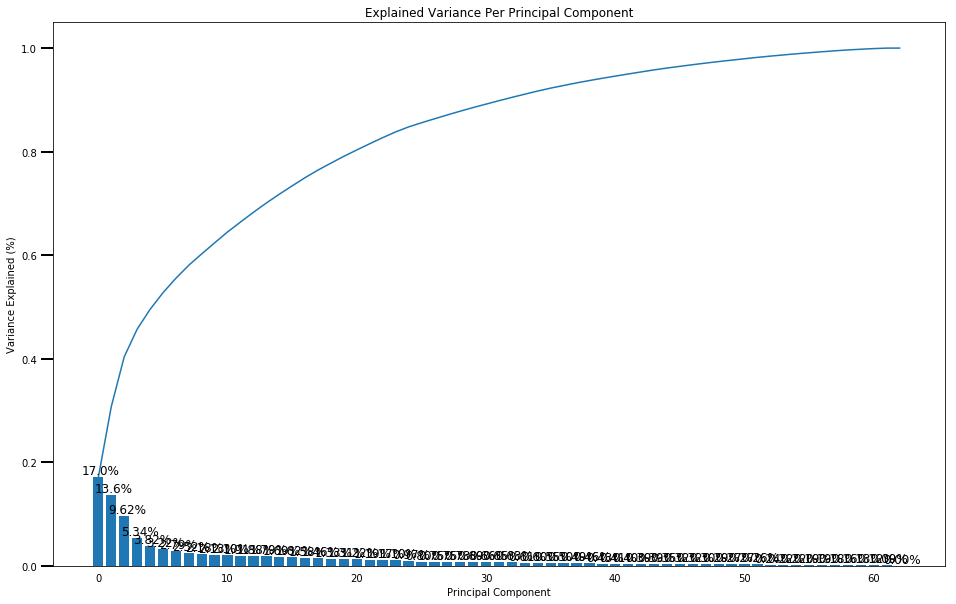

In [70]:
# Investigate the variance accounted for by each principal component.

# Make a scree plot


num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
 
plt.figure(figsize=(16, 10))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)
 
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component');

In [71]:
print(num_components)

63


In [72]:
sum(vals)

1.0000000000000002

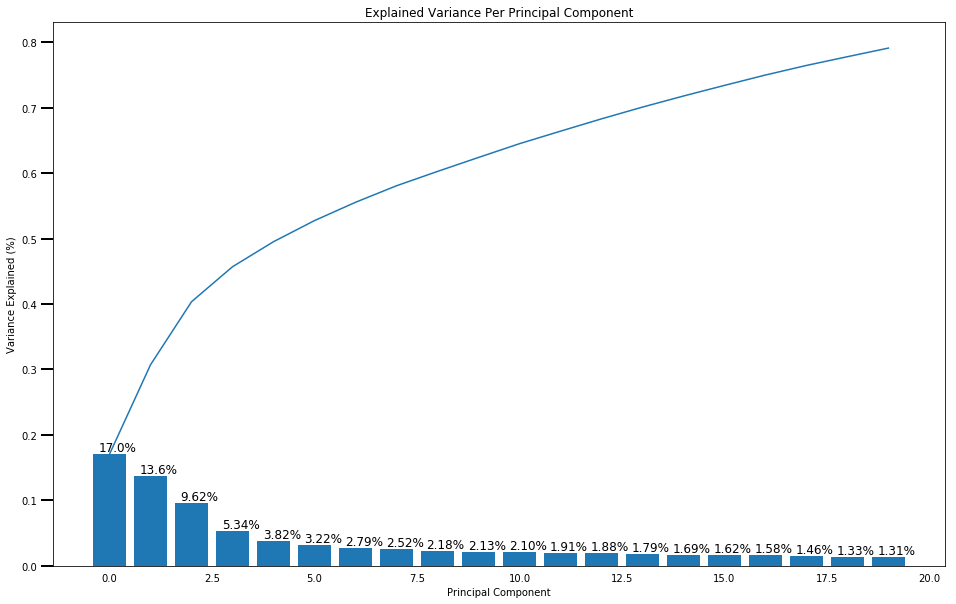

In [73]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Apply PCA to the data.

pca = PCA(20)

azdias_pca = pca.fit_transform(azdias)

# Make a scree plot


num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
 
plt.figure(figsize=(16, 10))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)
 
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component');

In [74]:
print(num_components)

20


In [75]:
sum(vals)

0.79091991720245514

### Discussion 2.2: Perform Dimensionality Reduction


### Sklearn's default PCA parameters result in 63 components, which means it isn't getting rid of any of our initial features.

### However, when we run PCA with only 20 components, we still retain 80% of the variability explanation.

### Step 2.3: Interpret Principal Components

Now that I have my transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [76]:
def do_pca(n_comp, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_comp)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [77]:
pca, X_pca = do_pca(3, azdias)

In [78]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def examine_pca(pca, selected_component, df):

    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions

    new_cols = components.columns[components.ix[components.index[selected_component]].argsort()]


    return components[new_cols]

In [79]:
components = examine_pca(pca, 0, azdias)
components

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


,MOBI_REGIO,PLZ8_ANTG1,KBA05_ANTG1,FINANZ_MINIMALIST,KBA05_GBZ,KONSUMNAEHE,PLZ8_GBZ,INNENSTADT,BALLRAUM,CI2_LifeStage,...,ARBEIT,KBA05_ANTG4,PLZ8_ANTG2,FINANZ_HAUSBAUER,EWDICHTE,ORTSGR_KLS9,HH_EINKOMMEN_SCORE,CI2_Wealth,PLZ8_ANTG4,PLZ8_ANTG3
Dimension 1,-0.2430,-0.2272,-0.2266,-0.2187,-0.2180,-0.1686,-0.1685,-0.1655,-0.1279,-0.1254,...,0.1444,0.1538,0.1548,0.1632,0.1963,0.1981,0.2043,0.2080,0.2208,0.2276
Dimension 2,-0.0848,-0.0871,-0.0751,0.0685,-0.0844,-0.0673,-0.0691,-0.0718,-0.0584,0.0032,...,0.0656,0.0664,0.0616,0.1160,0.0886,0.0872,0.0544,0.0722,0.0855,0.0895
Dimension 3,-0.0292,-0.0457,-0.0232,0.1558,-0.0264,-0.0373,-0.0383,-0.0422,-0.0342,-0.0087,...,0.0348,0.0269,0.0298,-0.0417,0.0454,0.0461,-0.0183,0.0277,0.0451,0.0447


In [80]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components = examine_pca(pca, 1, azdias)
components

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


,SEMIO_REL,PJ_Decade,FINANZ_SPARER,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_UNAUFFAELLIGER,SEMIO_KULT,FINANZ_ANLEGER,SEMIO_FAM,SEMIO_RAT,...,ANREDE_KZ,SEMIO_KAEM,SEMIO_KRIT,FINANZ_HAUSBAUER,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
Dimension 1,0.1096,0.0981,0.1434,0.0859,0.1124,0.0707,0.0702,0.0668,0.0756,0.0923,...,0.0084,0.0407,0.0046,0.1632,0.0372,-0.0165,-0.0699,-0.0732,-0.1111,-0.1161
Dimension 2,-0.2553,-0.2524,-0.2372,-0.2319,-0.2286,-0.2285,-0.2196,-0.2051,-0.1846,-0.1711,...,0.0903,0.1118,0.1148,0.1160,0.1194,0.1637,0.1843,0.2313,0.2340,0.2613
Dimension 3,0.0696,-0.1079,-0.1064,-0.0790,-0.0786,-0.0999,0.2355,-0.1890,0.2500,-0.2174,...,-0.3685,-0.3369,-0.2762,-0.0417,0.0909,0.1085,0.0646,-0.1763,0.1011,0.0791


In [81]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components = examine_pca(pca, 2, azdias)
components

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_RAT,FINANZ_ANLEGER,SEMIO_ERL,PJ_Decade,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,...,SEMIO_REL,ALTERSKATEGORIE_GROB,W_KEIT_KIND_HH,FINANZ_VORSORGER,RETOURTYP_BK_S,FINANZ_MINIMALIST,SEMIO_KULT,SEMIO_FAM,SEMIO_SOZ,SEMIO_VERT
Dimension 1,0.0084,0.0407,0.0243,0.0046,0.0923,0.0668,-0.0732,0.0981,0.1434,0.0707,...,0.1096,-0.1161,0.0372,-0.1111,-0.0165,-0.2187,0.0702,0.0756,0.0421,-0.0409
Dimension 2,0.0903,0.1118,0.0704,0.1148,-0.1711,-0.2051,0.2313,-0.2524,-0.2372,-0.2285,...,-0.2553,0.2613,0.1194,0.2340,0.1637,0.0685,-0.2196,-0.1846,-0.1030,-0.0691
Dimension 3,-0.3685,-0.3369,-0.3144,-0.2762,-0.2174,-0.1890,-0.1763,-0.1079,-0.1064,-0.0999,...,0.0696,0.0791,0.0909,0.1011,0.1085,0.1558,0.2355,0.2500,0.2623,0.3452


### Discussion 2.3: Interpret Principal Components


### The First Principal Component - Many Houses, Low Movement, and Low Minimalism

#### Positively Correlates with large numbers of family houses:
1.  PLZ8_ANT3 - Number of 6-10 family houses in the PLZ8 region
2.  PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region

#### Negatively Correlates with increased movement and increased minimalism:
1.  MOBI_REGIO - The higher the number, the lower the movement
2.  FINANZ_MINIMALIST - The higher the number, the lower the minimalism

### The Second Principal Component - Older Individuals who are less focused on events and more focused on religion

#### Positively Correlates with being older and less event-minded:
1.  ALTERSKATEGORIE_GROB - The higher the number, the older the person probably is
2.  SEMIO_ERL - The higher the number, the lower the event-mindedness

##### Negatively Correlates with being young and non-religious:
1.  SEMIO_REL - The higher the number, the lower the religiousness
2.  PJ_Decade - The higher the number, the younger the person is

### The Third Principal Component - Males who are not socially-minded dreamers

#### Positively Correlates with not being a socially-minded dreamer:
1.  SEMIO_VERT - The higher the number, the lower the "dreamfulness"
2.  SEMIO_SOZ - The higher the number, the lower the socially-mindedness

##### Negatively Correlates with being female and not having a combative attitude:
1.  ANREDE_KZ - The higher number is female
2.  SEMIO_KAEM - The higher the number, the lower the combative attitude

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [86]:
def do_pca(n_comp, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_comp)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [87]:
pca, X_pca = do_pca(20, azdias)

In [78]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
scores = []
k_mean_num = []

for i in range(1,21):
    kmeans = KMeans(i)
    model = kmeans.fit(X_pca)
    labels = model.predict(X_pca)
    score = model.score(X_pca)
    scores.append(-score)
    k_mean_num.append(i)

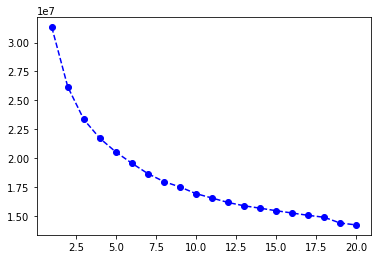

In [79]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(k_mean_num, scores, linestyle='--', marker='o', color='b');

In [89]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(19)
model = kmeans.fit(X_pca)
labels = model.predict(X_pca)

In [90]:
labels.shape

(797961,)

In [91]:
azdias['label'] = labels

In [92]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_Decade,PJ_Movement,CI2_Wealth,CI2_LifeStage,label
1,-1.766034,0.957933,-1.494605,1.537983,-1.040689,1.466048,0.958818,1.339234,-0.530442,1.085896,...,1.445477,0.565074,-0.167331,-0.127741,0.684580,1.165659,-0.553151,1.191245,-1.266353,16
2,0.201250,0.957933,-1.494605,0.864617,-1.766963,-0.570958,0.244259,1.339234,1.885219,1.085896,...,0.403451,0.565074,-0.167331,-0.127741,-0.789342,1.165659,1.875295,-0.865147,0.761951,7
3,1.184892,0.957933,0.683156,-0.482116,1.138133,-0.570958,-1.184858,-0.791347,-0.530442,-0.269840,...,-0.638575,0.565074,-1.170935,-0.998296,-0.052381,-0.232000,-0.553151,-1.550612,-0.590252,11
4,0.201250,-1.043914,0.683156,0.191250,0.411859,-1.249960,0.244259,-0.791347,-0.530442,1.085896,...,-0.638575,-0.347935,0.836273,0.307537,1.421541,-0.232000,-0.553151,0.505781,0.085850,9
5,-1.766034,0.957933,-0.042764,-1.155482,1.138133,-0.570958,-0.470299,1.339234,-0.530442,1.085896,...,1.445477,1.478082,-1.170935,-0.998296,-0.052381,-1.629658,-0.553151,1.191245,0.761951,14


### Discussion 3.1: Apply Clustering to General Population


#### I decided to cluster the population into 19 groups because that appears to be where we have our last major advancement by adding a cluster

### Step 3.2: Apply All Steps to the Customer Data

In [93]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [94]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)
customers = customers.fillna(customers.mean())
customers[customers.columns] = scaler.transform(customers[customers.columns])

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [109]:
customers.columns == azdias.drop(['label'], axis=1).columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

#### Cleaned Azdias and Cleaned Customers have the same columns

In [115]:
def do_pca_prefit(n_comp, data):
    pca = PCA(n_comp)
    pca.fit(azdias.drop(['label'], axis=1))
    X_pca = pca.transform(data)
    return pca, X_pca

In [116]:
pca_cust, X_pca_cust = do_pca_prefit(20, customers)

labels_cust = model.predict(X_pca_cust)
customers['label'] = labels_cust

In [117]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_Decade,PJ_Movement,CI2_Wealth,CI2_LifeStage,label
0,1.184892,-1.043914,1.409077,-1.155482,1.138133,-1.249960,-0.470299,-0.791347,1.885219,-1.625575,...,1.445477,1.478082,-2.174539,-1.433574,-1.526303,-1.629658,1.875295,-1.550612,0.085850,3
2,1.184892,0.957933,1.409077,-1.155482,1.138133,-1.249960,0.958818,0.629041,1.885219,-0.269840,...,-0.638575,-1.260944,-0.167331,-0.127741,-0.052381,-1.629658,1.875295,-0.179683,0.761951,15
3,1.184892,-1.043914,1.409077,-1.155482,1.138133,-0.570958,-1.184858,-0.791347,-0.530442,-0.269840,...,-0.638575,0.565074,-2.174539,-0.998296,-1.526303,-2.328487,-0.553151,-0.865147,0.761951,6
4,0.201250,-1.043914,-0.042764,-1.155482,0.411859,0.787046,1.673376,-0.791347,-0.530442,1.085896,...,-0.638575,-0.347935,-0.167331,-0.127741,-1.526303,-0.232000,-0.553151,0.505781,-1.266353,9
5,0.201250,-1.043914,1.409077,-1.155482,1.138133,-1.249960,-0.470299,-0.081153,1.885219,1.085896,...,1.445477,1.478082,-0.167331,0.742815,1.421541,-1.629658,1.875295,-0.179683,0.761951,3


### Step 3.3: Compare Customer Data to Demographics Data

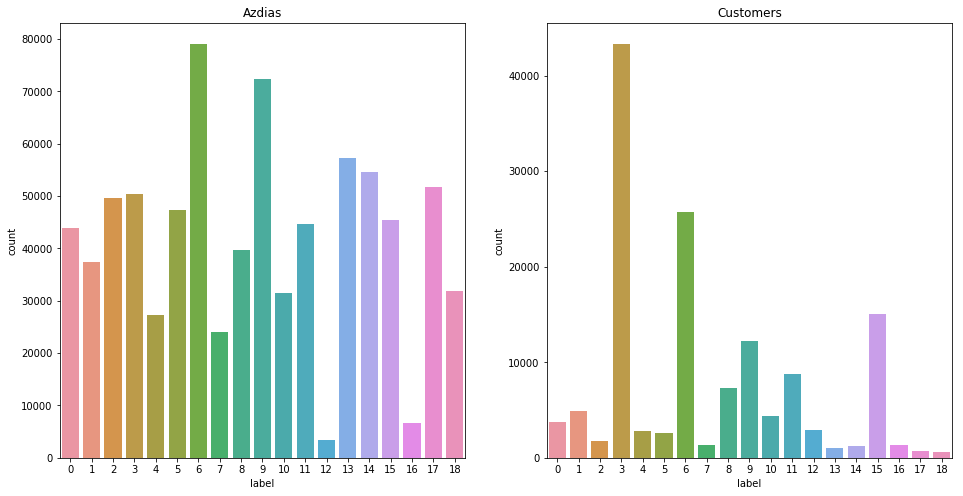

In [118]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16,8))
ax1.set_title('Azdias')
ax2.set_title('Customers')
sns.countplot(x="label", data=azdias, ax=ax1)
sns.countplot(x="label", data=customers, ax=ax2);

In [119]:
diff_df = pd.DataFrame(azdias.groupby(['label'])['ANREDE_KZ'].count() / len(azdias))

In [120]:
diff_df['customers'] = customers.groupby(['label'])['ANREDE_KZ'].count() / len(customers)

In [121]:
diff_df = diff_df.rename(index=str, columns = {'ANREDE_KZ': 'azdias'})

In [122]:
diff_df['cust-azdias'] = diff_df['customers'] - diff_df['azdias']

In [123]:
diff_df.sort_values(['cust-azdias'])

,azdias,customers,cust-azdias
label,,,
13,0.071837,0.007290,-0.064547
17,0.064894,0.005335,-0.059559
14,0.068353,0.008892,-0.059461
2,0.062177,0.012124,-0.050053
5,0.059310,0.017996,-0.041314
18,0.039808,0.004185,-0.035623
0,0.054948,0.026789,-0.028159
7,0.030023,0.009520,-0.020503
4,0.034277,0.019513,-0.014764


In [124]:
customers_inv = customers.drop(['label'], axis=1)

customers_inv[customers_inv.columns] = scaler.inverse_transform(customers_inv[customers_inv.columns])

customers_inv['label'] = customers['label']

In [125]:
customers_inv

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_Decade,PJ_Movement,CI2_Wealth,CI2_LifeStage,label
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,5.000000,5.000000,1.0,2.0,1.0,2.0,2.0,1.0,3.0,3
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,3.000000,2.000000,3.0,5.0,3.0,2.0,2.0,3.0,4.0,15
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,3.000000,4.000000,1.0,3.0,1.0,1.0,1.0,2.0,4.0,6
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,3.000000,3.000000,3.0,5.0,1.0,4.0,1.0,4.0,1.0,9
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,5.000000,5.000000,3.0,7.0,5.0,2.0,2.0,3.0,4.0,3
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,5.000000,5.000000,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3
7,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,3.000000,3.000000,3.0,4.0,3.0,2.0,2.0,1.0,5.0,3
8,4.0,2.0,2.0,2.0,5.0,1.0,1.0,5.0,0.0,2.0,...,5.000000,4.000000,3.0,8.0,3.0,1.0,1.0,5.0,5.0,10
9,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,5.000000,5.000000,3.0,6.0,4.0,4.0,2.0,1.0,5.0,3
11,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,1.0,...,3.000000,3.000000,2.0,5.0,1.0,2.0,2.0,1.0,4.0,3


In [126]:
customers_inv['ANREDE_KZ'].unique()

array([ 1.,  2.])

In [127]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customers_inv['ALTERSKATEGORIE_GROB'][customers_inv['label'] == 3].value_counts()

4.000000    28744
3.000000    13977
1.000000      309
2.000000      252
3.487107       58
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [128]:
customers_inv['ANREDE_KZ'][customers_inv['label'] == 3].value_counts()

1.0    43340
Name: ANREDE_KZ, dtype: int64

In [129]:
customers_inv['PJ_Decade'][customers_inv['label'] == 3].value_counts()

2.000000    15076
3.000000    10524
1.000000     7694
4.000000     6811
5.000000     2985
6.000000      201
2.887997       49
Name: PJ_Decade, dtype: int64

In [130]:
customers_inv['PJ_Movement'][customers_inv['label'] == 3].value_counts()

2.000000    42874
1.000000      417
1.501182       49
Name: PJ_Movement, dtype: int64

In [131]:
customers_inv['CI2_Wealth'][customers_inv['label'] == 3].value_counts()

1.000000    19715
2.000000    12514
4.000000     5738
3.000000     3506
5.000000     1755
2.598754      112
Name: CI2_Wealth, dtype: int64

In [132]:
customers_inv['CI2_LifeStage'][customers_inv['label'] == 3].value_counts()

4.000000    18695
5.000000    10695
3.000000     7309
2.000000     3919
1.000000     2610
3.368202      112
Name: CI2_LifeStage, dtype: int64

### Cluster 3 is the most over-represented in the customer data relative to the general population.  Cluster 3 is composed primarily of:

1.  Age > 60, born from 1950-1969
2.  Males
3.  Prosperous or Wealthy
4.  Older Families & Mature Couples or Elders in Retirement

In [133]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

customers_inv['ALTERSKATEGORIE_GROB'][customers_inv['label'] == 13].value_counts()

2.000000    408
1.000000    379
3.000000    205
4.000000     29
3.487107     12
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [134]:
customers_inv['ANREDE_KZ'][customers_inv['label'] == 13].value_counts()

1.0    1033
Name: ANREDE_KZ, dtype: int64

In [135]:
customers_inv['PJ_Decade'][customers_inv['label'] == 13].value_counts()

6.000000    598
5.000000    304
4.000000     95
2.887997     21
3.000000     10
2.000000      4
1.000000      1
Name: PJ_Decade, dtype: int64

In [136]:
customers_inv['PJ_Movement'][customers_inv['label'] == 13].value_counts()

1.000000    780
2.000000    232
1.501182     21
Name: PJ_Movement, dtype: int64

In [137]:
customers_inv['CI2_Wealth'][customers_inv['label'] == 13].value_counts()

5.000000    431
4.000000    420
3.000000    134
2.000000     30
1.000000     16
2.598754      2
Name: CI2_Wealth, dtype: int64

In [138]:
customers_inv['CI2_LifeStage'][customers_inv['label'] == 13].value_counts()

1.000000    685
4.000000    164
5.000000     95
3.000000     51
2.000000     36
3.368202      2
Name: CI2_LifeStage, dtype: int64

### Cluster 13 is the most under-represented in the customer data relative to the general population.  Cluster 13 is composed primarily of:

1.  Age younger than 45, born from 1980-1999
2.  Males
3.  From the Mainstream movement
4.  Less Affluent or Poorer
5.  Pre-Family Couples & Singles

### Discussion 3.3: Compare Customer Data to Demographics Data

Based on our clustering, we were able to show that affluent men over 60 are popular with the mail-order company while poorer, pre-family, young men are unpopular with the company.  From this, it seems that the company may want to focus their marketing more on the older, affluent male population in Germany.